# Initial Imports

In [1]:
import pickle
import pandas as pd
import numpy as np
import nltk
from textblob import TextBlob
import matplotlib.pyplot as plt
import math
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

Notes from class:
- add Hurricane harvey to stopword list, or change max document frequency

# Read in data from mongo & make metadata db

In [2]:
import json
from pymongo import MongoClient

client = MongoClient()
db = client.twitter
tweets_collection = db.tweets
tweets_meta = db.meta

In [3]:
def get_tweet_metadata(tweet):
    meta_dict = {}
    meta_dict['storm'] = 'Harvey'
    try: meta_dict['id']  = tweet['id']
    except: pass
    try: meta_dict['user_id']  = tweet['entities']['user_mentions'][0]['id']
    except: pass
    try: meta_dict['user_name']  = tweet['entities']['user_mentions'][0]['name']
    except: pass
    try: meta_dict['datetime'] = tweet['created_at']
    except: pass
    try: meta_dict['media'] = tweet['entities']['media'][0]['media_url']
    except: pass
    try: meta_dict['media_type'] = tweet['extended_entities']['media'][0]['type']
    except: pass
    try: meta_dict['coords'] = tweet['geo']['coordinates']
    except: pass
    try: meta_dict['text'] = tweet['text']
    except: pass
    try: 
        hashtags_text = tweet['entities']['hashtags']
        hashtags = []
        for i in hashtags_text:
            hashtags.append(i['text'])
        meta_dict['hashtags'] = hashtags
    except: pass
    try: meta_dict['followers'] = tweet['extended_entities']['media'][0]['additional_media_info']['source_user']['followers_count']
    except: pass
    try: meta_dict['following'] = tweet['extended_entities']['media'][0]['additional_media_info']['source_user']['friends_count']
    except: pass
    try: meta_dict['user_location'] = tweet['extended_entities']['media'][0]['additional_media_info']['source_user']['location']
    except: pass
    try: meta_dict['retweets'] = tweet['retweet_count']
    except: pass
    return meta_dict


In [5]:
# for tweet in tweets_collection.find():
#     meta_dict = get_tweet_metadata(tweet)
#     tweets_meta.insert_one(meta_dict)

# Read into Pandas & Clean metadata

In [72]:
cursor = tweets_meta.find()
df =  pd.DataFrame(list(cursor))

In [71]:
df.sort_values('id').tail()

NameError: name 'df' is not defined

## Brink in 50k tweets from 8/25

In [89]:
missing_bunch = pd.read_csv('ISCRAM18_datasets/Harvey_missing_ids_50K.csv',sep='\t')

In [90]:
missing_bunch.columns = ['datetime', 'text']

In [95]:
df_agg = df.merge(missing_bunch, left_on=['text','datetime'], right_on=['text','datetime'], how='outer')

In [121]:
len(missing_bunch)

49538

## Fix datetime

In [42]:
import time
from datetime import time
from datetime import datetime
import re

In [99]:
timestamp = []
date_out = []
weekday = []

dates = df_agg['datetime']
for i in dates:
    date = re.sub('\+0000 ', '', i)
    datetime = datetime.strptime(date, "%a %b %d %X %Y") 
    timestamp.append(datetime)
    date_out.append(datetime.date())
    weekday.append(datetime.weekday())

In [100]:
df_agg['timestamp'] = timestamp
df_agg['date'] = date_out
df_agg['weekday'] = weekday


In [9]:
df_agg['date'] = pd.to_datetime(df_agg['date'])  

In [137]:
df_agg.sort_values('timestamp').tail()

,_id,coords,datetime,followers,following,hashtags,id,media,media_type,retweets,storm,text,user_id,user_location,user_name,timestamp,date,weekday
2199779,5b0c5dc0b7111907d87a5e1f,NaN,Wed Aug 30 21:58:52 +0000 2017,NaN,NaN,[],9.030142e+17,NaN,NaN,488.0,Harvey,RT @davidschneider: I don’t believe thunderbol...,2.009802e+07,NaN,David Schneider,2017-08-30 21:58:52,2017-08-30,2
2199780,5b0c5dc0b7111907d87a5e20,NaN,Wed Aug 30 21:58:52 +0000 2017,NaN,NaN,[],9.030142e+17,NaN,NaN,90.0,Harvey,RT @Independent: Trump failed to meet a single...,1.697333e+07,NaN,The Independent,2017-08-30 21:58:52,2017-08-30,2
2199782,5b0c5dc0b7111907d87a5e23,NaN,Wed Aug 30 21:58:52 +0000 2017,NaN,NaN,[],9.030142e+17,NaN,NaN,5.0,Harvey,.@DCFSSecretary is on the ground with @Louisia...,7.666628e+17,NaN,Marketa G. Walters,2017-08-30 21:58:52,2017-08-30,2
2199763,5b0c5dc0b7111907d87a5e0c,NaN,Wed Aug 30 21:58:52 +0000 2017,NaN,NaN,[Harvey],9.030142e+17,NaN,NaN,18189.0,Harvey,RT @OmarVillafranca: Remember the heartbreakin...,1.577302e+07,NaN,Omar Villafranca,2017-08-30 21:58:52,2017-08-30,2
2199725,5b0c5dc0b7111907d87a5de7,NaN,Wed Aug 30 21:58:52 +0000 2017,NaN,NaN,[Harvey],9.030142e+17,NaN,NaN,445.0,Harvey,RT @ABC: Firefighter saving Hurricane #Harvey ...,2.878549e+07,NaN,ABC News,2017-08-30 21:58:52,2017-08-30,2


In [48]:
df_agg[df_agg['id'] == 902919069116112897]

,_id,coords,datetime,followers,following,hashtags,id,media,media_type,retweets,storm,text,user_id,user_location,user_name,timestamp,date,weekday
1643671,5b0c5cb7b7111907d871e1d5,NaN,Wed Aug 30 15:40:56 +0000 2017,NaN,NaN,[Harvey],9.029191e+17,NaN,NaN,11.0,Harvey,RT @rapidcraft: Hi @USAGSessions you may want ...,104556243.0,NaN,Barry Choom,2017-08-30 15:40:56,2017-08-30,2


In [2]:
# pickle.dump( df, open( "full_df_from_mongo.pkl", "wb" ) )
# pickle.dump( df_agg, open( "full_df_from_mongo_and_missing.pkl", "wb" ) )
df_agg = pickle.load(open("full_df_from_mongo_and_missing.pkl", "rb"))

**Note: Define working sample date here**

In [36]:
df_slice = df_agg[df_agg['date']== '2017-08-29']
df_sample = df_slice.sample(n=30000,random_state=1)

In [67]:
print(format(list(df_sample['id'])[1], 'f'))

902679321546022912.000000


## Text cleaning
need to remove:
    - remove retweets
    - stop words
    - non-ascii characters
    - punctuation
    - numbers
    - URLs
    - hashtags
    

### remove retweets

In [78]:
df_noRT = df_sample[df_sample['text'].astype(str).str.startswith('RT') == False]
len(df_noRT)

4723

In [79]:
documents = np.asarray(df_noRT.text)

In [88]:
import string
cleaned_docs = []
hashtags = []
for doc in documents:
    hashtag = re.compile('#[a-zA-Z0-9]*')
    match = hashtag.findall(doc)
    hashtags.append(match)
    doc = re.sub('@\S*', '', doc)
#     doc = re.sub('#', '', doc)
    doc = re.sub('&amp', 'and', doc)
    doc = re.sub('&amp ', 'and', doc)
    doc = re.sub('https:\S*', '', doc)
    doc = re.sub('\\n', ' ', doc)
    doc = re.sub('[0-9]', '', doc)
    exclude = set('!"$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'+'…')
    doc = ''.join(ch for ch in doc if ch not in exclude)
    cleaned_docs.append(doc)

## Create new dataframe with cleaned docs and hashtags

In [83]:
df_cleaned_docs = pd.DataFrame(columns = ['id', 'coords','hashtags', 'full_text', 'cleaned_text'])

In [91]:
df_cleaned_docs.id = df_noRT.id
df_cleaned_docs.coords = df_noRT.coords
df_cleaned_docs.hashtags = hashtags
df_cleaned_docs.full_text = df_noRT.text
df_cleaned_docs.cleaned_text = cleaned_docs
df_cleaned_docs.head()

,id,coords,hashtags,full_text,cleaned_text
538904,9.026541e+17,NaN,"[#HurricaneHarvey, #pixelart]",Impressive setup for $SMH on https://t.co/MIt...,Impressive setup for SMH on #HurricaneHarvey...
187190,9.026046e+17,NaN,[#ASL],Yes! #ASL should ALWAYS be visible! https://t....,Yes #ASL should ALWAYS be visible
558260,9.026567e+17,NaN,[#Harvey],@altUSEPA Worth noting #Harvey is an example o...,Worth noting #Harvey is an example of phenome...
336391,9.026260e+17,NaN,"[#HurricaneHarvey, #HurricaneKatrina]",How the devastation of #HurricaneHarvey compar...,How the devastation of #HurricaneHarvey compar...
483931,9.026465e+17,NaN,[],No. Words. https://t.co/JX4ngihDVx,No Words


In [3]:
# pickle.dump( df_cleaned_docs, open( "df_cleaned_docs_for_pickup.pkl", "wb" ) )

# df_cleaned_docs = pickle.load(open("df_cleaned_docs_for_pickup.pkl", "rb"))
# cleaned_docs=list(df_cleaned_docs.cleaned_text)


# Sentiment

In [93]:
df_cleaned_docs_sentiment = pd.DataFrame(columns = ['id', 'polarity','subjectivity'])

In [94]:
polarity = []
subjectivity = []
for i in cleaned_docs:
    sentiment = TextBlob(i).sentiment
    polarity.append(sentiment[0])
    subjectivity.append(sentiment[1])

In [95]:
df_cleaned_docs_sentiment.id = df_noRT.id
df_cleaned_docs_sentiment.polarity = polarity
df_cleaned_docs_sentiment.subjectivity = subjectivity
df_cleaned_docs_sentiment.head()

,id,polarity,subjectivity
538904,9.026541e+17,1.0000,1.0000
187190,9.026046e+17,0.0000,0.0000
558260,9.026567e+17,0.0875,0.2375
336391,9.026260e+17,0.0000,0.0000
483931,9.026465e+17,0.0000,0.0000


In [97]:
len(df_cleaned_docs_sentiment)

4723

In [98]:
df_cleaned_docs_agg = df_cleaned_docs.merge(df_cleaned_docs_sentiment, left_on='id', right_on='id', how='outer')

In [99]:
df_cleaned_docs_agg

,id,coords,hashtags,full_text,cleaned_text,polarity,subjectivity
0,9.026541e+17,NaN,"[#HurricaneHarvey, #pixelart]",Impressive setup for $SMH on https://t.co/MIt...,Impressive setup for SMH on #HurricaneHarvey...,1.000000,1.000000
1,9.026046e+17,NaN,[#ASL],Yes! #ASL should ALWAYS be visible! https://t....,Yes #ASL should ALWAYS be visible,0.000000,0.000000
2,9.026567e+17,NaN,[#Harvey],@altUSEPA Worth noting #Harvey is an example o...,Worth noting #Harvey is an example of phenome...,0.087500,0.237500
3,9.026260e+17,NaN,"[#HurricaneHarvey, #HurricaneKatrina]",How the devastation of #HurricaneHarvey compar...,How the devastation of #HurricaneHarvey compar...,0.000000,0.000000
4,9.026465e+17,NaN,[],No. Words. https://t.co/JX4ngihDVx,No Words,0.000000,0.000000
5,9.026458e+17,NaN,[],I want him dead in a fucking hurricane https:/...,I want him dead in a fucking hurricane,-0.400000,0.600000
6,9.026283e+17,NaN,"[#nurses, #HarveyRelief]",If you know out of state #nurses coming to hel...,If you know out of state #nurses coming to hel...,0.000000,0.000000
7,9.026627e+17,NaN,"[#TropicalStormHarvey, #Houston, #HurricaneHar...","#TropicalStormHarvey Causes Levee Breach, Over...",#TropicalStormHarvey Causes Levee Breach Overf...,0.100000,0.400000
8,9.026694e+17,NaN,"[#HomeDepot, #BleedOrange]",This is why we work for #HomeDepot This is why...,This is why we work for #HomeDepot This is why...,0.000000,0.000000
9,9.026515e+17,NaN,"[#Harvey, #IamVZ]",Verizon is committing $10 million to support H...,Verizon is committing million to support Hurr...,0.000000,0.000000


# NER

In [100]:
from nltk.tag import StanfordNERTagger
from nltk.tokenize import word_tokenize

In [101]:
st = StanfordNERTagger('english.all.3class.distsim.crf.ser.gz','stanford-ner.jar',encoding='utf-8')
text = 'While in France, Christine Lagarde discussed short-term stimulus efforts in a recent interview with the Wall Street Journal.'

/home/ubuntu/anaconda3/lib/python3.6/site-packages/nltk/tag/stanford.py:183: DeprecationWarning: 
The StanfordTokenizer will be deprecated in version 3.2.5.
Please use nltk.tag.corenlp.CoreNLPPOSTagger or nltk.tag.corenlp.CoreNLPNERTagger instead.
  super(StanfordNERTagger, self).__init__(*args, **kwargs)


In [102]:
tokenized_text = word_tokenize(text)
classified_text = st.tag(tokenized_text)

print(classified_text)

[('While', 'O'), ('in', 'O'), ('France', 'LOCATION'), (',', 'O'), ('Christine', 'PERSON'), ('Lagarde', 'PERSON'), ('discussed', 'O'), ('short-term', 'O'), ('stimulus', 'O'), ('efforts', 'O'), ('in', 'O'), ('a', 'O'), ('recent', 'O'), ('interview', 'O'), ('with', 'O'), ('the', 'O'), ('Wall', 'ORGANIZATION'), ('Street', 'ORGANIZATION'), ('Journal', 'ORGANIZATION'), ('.', 'O')]


In [103]:
from itertools import groupby
for tag, chunk in groupby(classified_text, lambda x:x[1]):
    if tag != "O":
        print("%-12s"%tag, " ".join(w for w, t in chunk))

LOCATION     France
PERSON       Christine Lagarde
ORGANIZATION Wall Street Journal


# LDA

In [85]:
from sklearn.feature_extraction import stop_words
from nltk.corpus import stopwords

custom = ['like','just','rt','I\'ve', 'I', 'hes','thing','does','want', 'going','ive','wanna','way','bit', 'harvey', 'houston','hurricaneharvey', 'im','hurricane', 'know','live','say']
full_stop =list(stop_words.ENGLISH_STOP_WORDS)
full_stop.extend(stopwords.words('english'))
full_stop.extend(custom)
stop_set = set(full_stop)

## Sanity test

In [86]:
train_set = ("The sky sky is blue.", "The sun is bright.")
# test_set = ("The sun in the sky is bright.", 
#     "We can see the shining sun, the bright sun.")

vectorizer = CountVectorizer(stop_words=stop_set)
document_term_matrix = vectorizer.fit_transform(train_set)
print(vectorizer.vocabulary_)

{'sky': 2, 'blue': 0, 'sun': 3, 'bright': 1}


In [87]:
document_term_matrix.toarray()[0]

array([1, 0, 2, 0], dtype=int64)

## On true data

In [88]:
# Create a CountVectorizer for parsing/counting words
vectorizer = CountVectorizer(ngram_range=(1, 2), max_df=10000,analyzer='word',
                                   stop_words=stop_set)
document_term_matrix = vectorizer.fit_transform(test)


In [89]:
n_components = 10
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=10.,
                                random_state=0)


In [90]:
document_topics = lda.fit_transform(document_term_matrix)

In [91]:
print("lda.components_.shape: {}".format(lda.components_.shape))

lda.components_.shape: (10, 26304)


In [92]:
sorting = np.argsort(lda.components_, axis = 1)[:,::-1]

In [93]:
feature_names = np.array(vectorizer.get_feature_names())

In [94]:
import mglearn
mglearn.tools.print_topics(topics=range(n_components), feature_names =feature_names,sorting =sorting, topics_per_chunk = 1, n_words = 10)

topic 0       
--------      
people        
really        
help          
storm         
tx            
victims       
life          
red           
red cross     
cross         


topic 1       
--------      
thanks        
water         
donations     
latest        
come          
support       
help          
today         
flooding      
daily         


topic 2       
--------      
texas         
help          
victims       
trump         
prayers       
help victims  
response      
rescue        
thank         
president     


topic 3       
--------      
news          
climate       
disaster      
change        
natural       
houstonstrong 
climate change
make          
link          
fake          


topic 4       
--------      
relief        
efforts       
donate        
relief efforts
kardashians   
contribute    
plate         
step          
step plate    
help          


topic 5       
--------      
right         
disasters     
victims       
flood         


In [95]:
#get sample from category
climate = np.argsort(document_topics[:,5])[::-1]
for i in climate[:10]:
    print(test[i])

  Please RT Those impacted by #HurricaneHarveyDr Turner is offering FREE virtual healthcare th 
Hurricane Harvey Victims Turn to Social Media for Assistance  The Wall Street Journal 
#HurricaneHarvey #TexasFloods 🇨🇱 #GalvestonTx #HoustonTx #DickinsonTx #PearlandTx #CypressTx #HarrisCounty 
Yes he is Cruelandheartless  #LockHimUp #LockThemAllUp #TRUMPRUSSIA #TRAITORTRUMPNSTAFF #IllegitimatePOTUS 
 Please RT Those impacted by #HurricaneHarveyDr Turner is offering FREE virtual healthcare thru 
 Please RT Those impacted by #HurricaneHarveyDr Turner is offering FREE virtual healthcare thru 
People pay millions for a indoor pool Im about to have one for free Your fav could never #HurricaneHarvey
Hurricane Harvey ratchets up pressure for OPEC to rebalance the market  #EnergyNews
Hurricane Harvey ratchets up pressure for OPEC to rebalance the market  #EnergyNews
About  of Hurricane Harvey victims do not have flood insurance face big bills 


In [51]:
len((lda.components_).T)

26784

In [56]:
#plot top words per topic
test_df = pd.DataFrame(columns = range(0,n_components))
test_df = pd.DataFrame((lda.components_).T)
test_df['word'] = feature_names


In [70]:
test_df.sort_values(2, ascending = False).head()

,0,1,2,3,4,5,6,7,8,9,word
22690,35.742295,0.100066,150.081622,61.982108,0.100063,11.930412,0.100077,67.382286,92.123587,0.100115,texas
10847,54.151550,44.026991,109.296519,102.892657,0.100081,140.234393,0.100083,0.100075,61.415326,18.432322,houston
5545,0.100071,0.100194,86.379726,0.100762,0.100074,0.100058,0.100112,0.100035,0.100096,0.100065,disaster
15199,0.100048,0.100049,77.767381,0.100028,0.100039,0.100033,0.100072,0.100042,0.100038,0.100048,natural
25607,0.100058,0.100063,74.005338,0.100063,0.100048,0.100092,0.100113,0.100078,0.100084,0.100047,water


In [96]:
# import pyLDAvis.sklearn
# tweets_vis_data = pyLDAvis.sklearn.prepare(lda, document_term_matrix, vectorizer )
# pyLDAvis.display(tweets_vis_data)

## Try again with fewer topics

In [9]:
tokenized_text = word_tokenize(text)
classified_text = st.tag(tokenized_text)

print(classified_text)

[('While', 'O'), ('in', 'O'), ('France', 'LOCATION'), (',', 'O'), ('Christine', 'PERSON'), ('Lagarde', 'PERSON'), ('discussed', 'O'), ('short-term', 'O'), ('stimulus', 'O'), ('efforts', 'O'), ('in', 'O'), ('a', 'O'), ('recent', 'O'), ('interview', 'O'), ('with', 'O'), ('the', 'O'), ('Wall', 'ORGANIZATION'), ('Street', 'ORGANIZATION'), ('Journal', 'ORGANIZATION'), ('.', 'O')]


LOCATION     France
PERSON       Christine Lagarde
ORGANIZATION Wall Street Journal


# Sentiment

(array([  777.,  1320.,  3932.,  4601.,  6321., 63615.,  8528.,  7781.,
         1402.,  2075.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

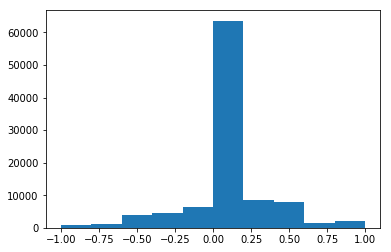

In [79]:
plt.hist(polarity)

In [70]:
sentiment_docs[0]

Sentiment(polarity=0.125, subjectivity=0.16666666666666666)

## Tweets over time

In [16]:
date_group = df.groupby(['date']).count().reset_index()

In [17]:
date_group

,date,_id,coords,datetime,followers,following,hashtags,id,media,media_type,retweets,storm,text,user_id,user_location,user_name,timestamp,weekday
0,2017-08-27,106945,80,106945,4719,4719,106945,106945,14720,14720,106945,106945,106945,88952,4719,88952,106945,106945
1,2017-08-29,627137,298,627137,22654,22654,627137,627137,57172,57172,627137,627137,627137,530703,22654,530703,627137,627137
2,2017-08-30,1465706,783,1465706,53852,53852,1465706,1465706,128284,128284,1465706,1465706,1465706,1256955,53852,1256955,1465706,1465706


In [18]:
date_group['date'] = date_group['date'].apply(str)

In [42]:
#note that there is a file of tweets missing ids that could be used, but it's missing some of the metadata
# missing_df = pd.read_csv('ISCRAM18_datasets/Harvey_missing_ids_50K.csv', sep='\t')
# len(missing_df)

In [19]:
import seaborn as sns

In [20]:
import matplotlib.pyplot as plt

<BarContainer object of 3 artists>

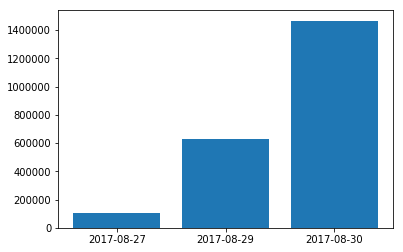

In [22]:
plt.bar(date_group['date'], date_group['id'])

## Sentiment Analysis